In [211]:
import pandas as pd
from pyquaternion import Quaternion
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [212]:
# Example dataset
data = {
    "Tanggal": ["13/12/2024", "16/12/2024", "17/12/2024", "18/12/2024", "19/12/2024", 
                "20/12/2024", "23/12/2024", "24/12/2024", "27/12/2024", "30/12/2024"],
    "Terakhir": [10050, 10100, 9900, 9800, 9675, 9650, 9775, 9750, 9800, 9675],
    "Sentimen": [0.0313, -0.2353, -0.3125, -0.2326, -0.3765, -0.3939, 0.4211, -0.2778, 0, -0.1818],
    "Faktor_Eksternal": [0, 1, -1, 1, 0, 1, 1, 0, 0, 1]
}

df = pd.DataFrame(data)


In [213]:
# Normalisasi Data
df["Deviasi"] = df["Terakhir"].diff()
baseline = df["Deviasi"].mean()
df["Baseline"] = baseline
df = df.dropna() #Drop semua data NaN
df["Baseline_Norm"] = 0
df["Deviasi_Mutlak"] = df["Deviasi"].abs()
df["Sentimen_Mutlak"] = df["Sentimen"].abs()
df["Faktor_Eksternal_Mutlak"] = df["Faktor_Eksternal"].abs()
df["Deviasi_Norm"] = (df["Deviasi_Mutlak"] - df["Deviasi_Mutlak"].min()) / (df["Deviasi_Mutlak"].max() - df["Deviasi_Mutlak"].min())
df["Sentimen_Norm"] = (df["Sentimen_Mutlak"] - df["Sentimen_Mutlak"].min()) / (df["Sentimen_Mutlak"].max() - df["Sentimen_Mutlak"].min())
df["Faktor_Eksternal_Norm"] = (df["Faktor_Eksternal_Mutlak"] - df["Faktor_Eksternal_Mutlak"].min()) / (df["Faktor_Eksternal_Mutlak"].max() - df["Faktor_Eksternal_Mutlak"].min())

In [214]:
quaternions = []
for index, row in df.iterrows():
    # Create quaternion with normalized values
    q = Quaternion(
        row["Baseline_Norm"],  # a (baseline normalized (0))
        row["Deviasi_Norm"],   # b (deviation normalized)
        row["Sentimen_Norm"],  # c (sentiment normalized)
        row["Faktor_Eksternal_Norm"]     # d (external factor normalized)
    )
    quaternions.append(q)
print(quaternions)
df["Norm"] = [q.norm for q in quaternions]

[Quaternion(0.0, 0.14285714285714285, 0.5587746378532416, 1.0), Quaternion(0.0, 1.0, 0.742104013298504, 1.0), Quaternion(0.0, 0.42857142857142855, 0.5523628591783425, 1.0), Quaternion(0.0, 0.5714285714285714, 0.8940869152220375, 0.0), Quaternion(0.0, 0.0, 0.9354072666824982, 1.0), Quaternion(0.0, 0.5714285714285714, 1.0, 1.0), Quaternion(0.0, 0.0, 0.659700783661838, 0.0), Quaternion(0.0, 0.14285714285714285, 0.0, 0.0), Quaternion(0.0, 0.5714285714285714, 0.43172643077653766, 1.0)]


In [215]:
# Print analysis summary
print("\nAnalysis Summary:")
print("Quaternion Norms (Real Volatility):")
print(df[["Tanggal", "Norm"]])


Analysis Summary:
Quaternion Norms (Real Volatility):
      Tanggal      Norm
1  16/12/2024  1.154399
2  17/12/2024  1.597097
3  18/12/2024  1.220155
4  19/12/2024  1.061095
5  20/12/2024  1.369302
6  23/12/2024  1.525297
7  24/12/2024  0.659701
8  27/12/2024  0.142857
9  30/12/2024  1.230007


Koefisien Korelasi antara Sentimen Hari Ini dan Deviasi: 0.6952


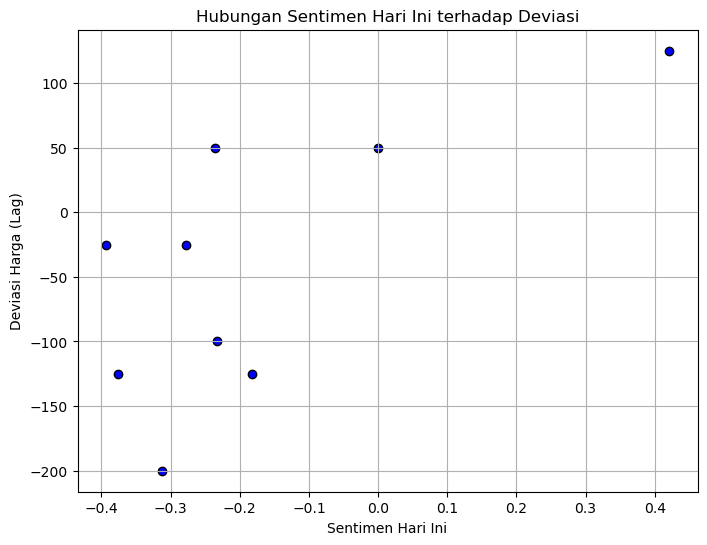

In [216]:
correlation = np.corrcoef(df["Sentimen"], df["Deviasi"])[0, 1]
print(f"Koefisien Korelasi antara Sentimen Hari Ini dan Deviasi: {correlation:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(df["Sentimen"], df["Deviasi"], color='blue', edgecolor='k')
plt.title("Hubungan Sentimen Hari Ini terhadap Deviasi")
plt.xlabel("Sentimen Hari Ini")
plt.ylabel("Deviasi Harga (Lag)")
plt.grid()
plt.show()

Koefisien Korelasi antara Faktor Eksternal dan Deviasi: 0.2699


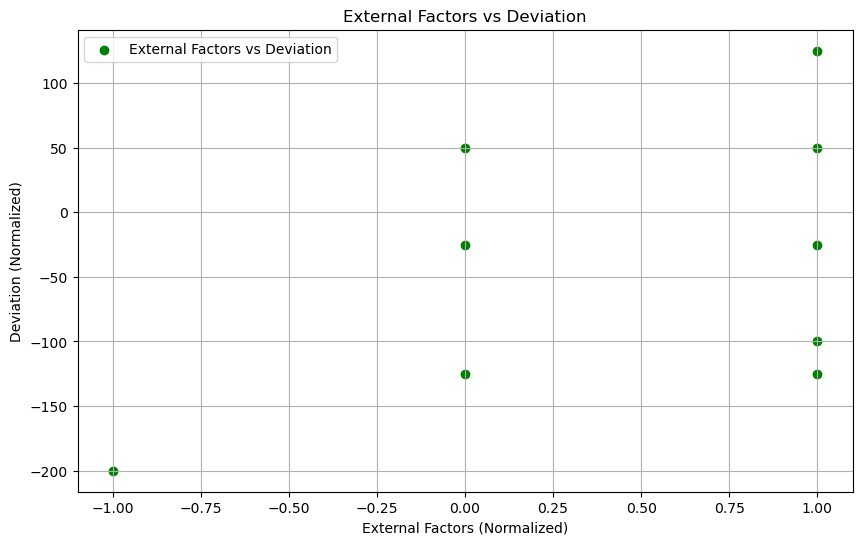

In [217]:
# Plot External Factors vs Deviation
correlation = np.corrcoef(df["Sentimen"], df["Faktor_Eksternal"])[0, 1]
print(f"Koefisien Korelasi antara Faktor Eksternal dan Deviasi: {correlation:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(df["Faktor_Eksternal"], df["Deviasi"], c="green", label="External Factors vs Deviation")
plt.xlabel("External Factors (Normalized)")
plt.ylabel("Deviation (Normalized)")
plt.title("External Factors vs Deviation")
plt.legend()
plt.grid()
plt.show()


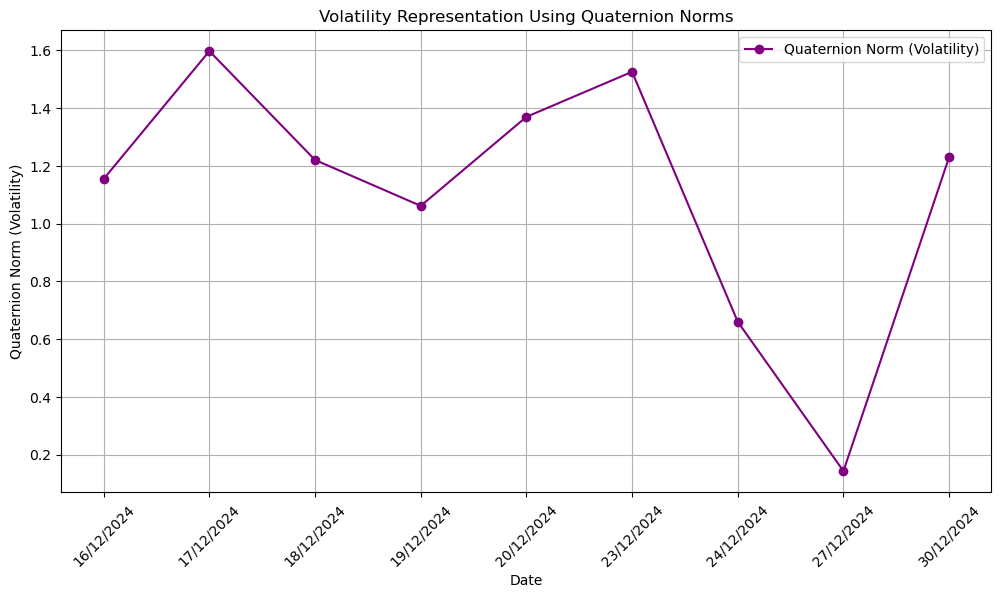

In [218]:
# Plot Quaternion Norms Over Time to Represent Volatility
plt.figure(figsize=(12, 6))
plt.plot(df["Tanggal"], df["Norm"], marker="o", color="purple", label="Quaternion Norm (Volatility)")
plt.xlabel("Date")
plt.ylabel("Quaternion Norm (Volatility)")
plt.title("Volatility Representation Using Quaternion Norms")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


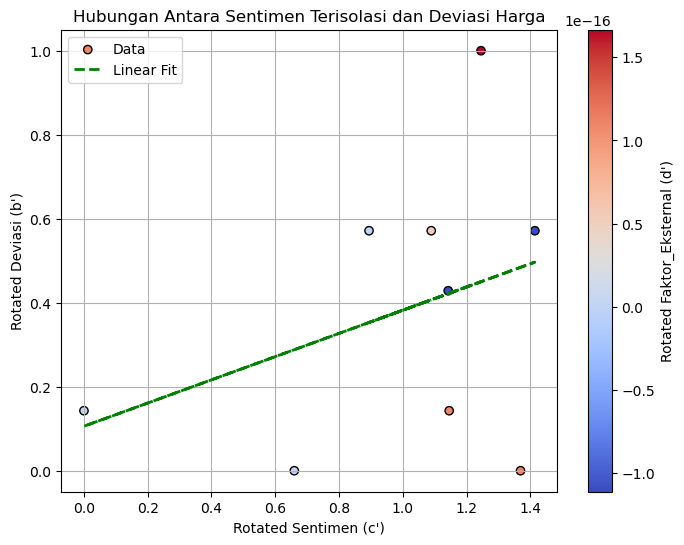

Slope (Kemiringan): 0.2763
Intercept (Titik Potong): 0.1059
Koefisien Korelasi antara Rotated Sentimen (c') dan Rotated Deviasi (b'): 0.3624


In [219]:
# Sudut rotasi untuk meminimalkan d'
angles = []
rotated_quaternions = []
for _, row in df.iterrows():
    c = row["Sentimen_Norm"]
    d = row["Faktor_Eksternal_Norm"]
    
    # Hitung sudut optimal
    if c == 0 and d == 0:
        theta = 0
    else:
        theta = np.arctan2(-d, c)
    angles.append(theta)

    # Rotasi quaternion
    q = Quaternion(0, row["Deviasi_Norm"], row["Sentimen_Norm"], row["Faktor_Eksternal_Norm"])
    r = Quaternion(axis=[1, 0, 0], angle=theta)
    q_rotated = r * q * r.inverse
    rotated_quaternions.append(q_rotated)

# Hasil rotasi ke DataFrame
df["Rotated_b"] = [q.elements[1] for q in rotated_quaternions]
df["Rotated_c"] = [q.elements[2] for q in rotated_quaternions]
df["Rotated_d"] = [q.elements[3] for q in rotated_quaternions]
df["Theta"] = angles

rotated_c = df["Rotated_c"].values.reshape(-1, 1)  # X (independen)
rotated_b = df["Rotated_b"].values  # Y (dependen)

# Regresi linear
reg_model = LinearRegression()
reg_model.fit(rotated_c, rotated_b)

# Prediksi nilai y berdasarkan x (Rotated_c)
predicted_b = reg_model.predict(rotated_c)

# Plot dengan garis regresi
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rotated_c, rotated_b, c=df["Rotated_d"], cmap="coolwarm", edgecolor="k", label="Data")
plt.plot(rotated_c, predicted_b, color="green", linestyle="--", linewidth=2, label="Linear Fit")

# Elemen visual
plt.colorbar(scatter, label="Rotated Faktor_Eksternal (d')")
plt.title("Hubungan Antara Sentimen Terisolasi dan Deviasi Harga")
plt.xlabel("Rotated Sentimen (c')")
plt.ylabel("Rotated Deviasi (b')")
plt.legend()
plt.grid()
plt.show()

# slope dan intercept
print(f"Slope (Kemiringan): {reg_model.coef_[0]:.4f}")
print(f"Intercept (Titik Potong): {reg_model.intercept_:.4f}")

# Hitung koefisien korelasi
correlation_rotated = np.corrcoef(df["Rotated_c"], df["Rotated_b"])[0, 1]
print(f"Koefisien Korelasi antara Rotated Sentimen (c') dan Rotated Deviasi (b'): {correlation_rotated:.4f}")


1    0.142857
2    1.000000
3    0.428571
4    0.571429
5    0.000000
6    0.571429
7    0.000000
8    0.142857
9    0.571429
Name: Rotated_b, dtype: float64 1    5.551115e-17
2    5.551115e-17
3    1.665335e-16
4    0.000000e+00
5    5.551115e-17
6    2.220446e-16
7    0.000000e+00
8    0.000000e+00
9    2.775558e-17
Name: Rotated_c, dtype: float64 1   -1.145526
2   -1.245278
3   -1.142412
4   -0.894087
5   -1.369302
6   -1.414214
7   -0.659701
8    0.000000
9   -1.089214
Name: Rotated_d, dtype: float64


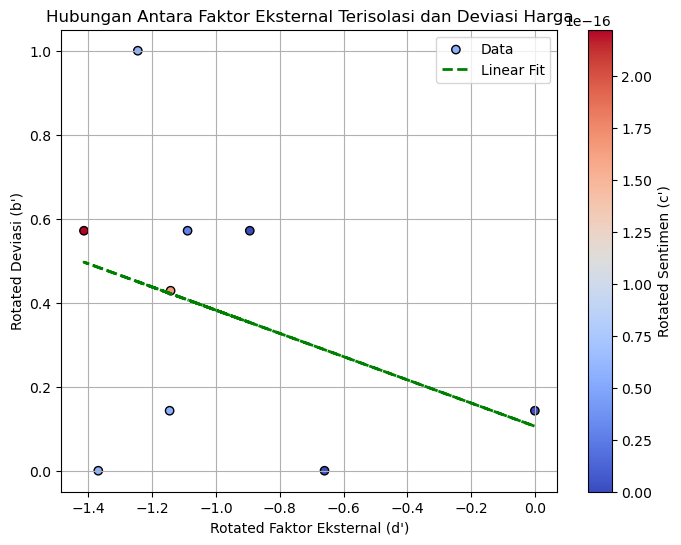

Slope (Kemiringan): -0.2763
Intercept (Titik Potong): 0.1059
Koefisien Korelasi antara Rotated Sentimen (c') dan Rotated Deviasi (b'): 0.2638


In [220]:
# Hitung sudut rotasi untuk meminimalkan d'
angles = []
rotated_quaternions = []
for _, row in df.iterrows():
    c = row["Sentimen_Norm"]
    d = row["Faktor_Eksternal_Norm"]
    
    # Hitung sudut optimal
    if c == 0 and d == 0:
        theta = 0
    else:
        theta = np.arctan2(-c, -d)
    angles.append(theta)

    # Rotasi quaternion
    q = Quaternion(0, row["Deviasi_Norm"], row["Sentimen_Norm"], row["Faktor_Eksternal_Norm"])
    r = Quaternion(axis=[1, 0, 0], angle=theta)
    q_rotated = r * q * r.inverse
    rotated_quaternions.append(q_rotated)

# Tambahkan hasil rotasi ke DataFrame
df["Rotated_b"] = [q.elements[1] for q in rotated_quaternions]
df["Rotated_c"] = [q.elements[2] for q in rotated_quaternions]
df["Rotated_d"] = [q.elements[3] for q in rotated_quaternions]
df["Theta"] = angles

print(df["Rotated_b"], df["Rotated_c"], df["Rotated_d"])

# Ekstrak data rotated_b (deviasi) dan rotated_c (sentimen)
rotated_d = df["Rotated_d"].values.reshape(-1, 1)  # X (independen)
rotated_b = df["Rotated_b"].values  # Y (dependen)

# Lakukan regresi linear
reg_model = LinearRegression()
reg_model.fit(rotated_d, rotated_b)

# Prediksi nilai y berdasarkan x (Rotated_c)
predicted_b = reg_model.predict(rotated_d)

# Buat plot dengan garis regresi
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rotated_d, rotated_b, c=df["Rotated_c"], cmap="coolwarm", edgecolor="k", label="Data")
plt.plot(rotated_d, predicted_b, color="green", linestyle="--", linewidth=2, label="Linear Fit")

# Tambahkan elemen visual
plt.colorbar(scatter, label="Rotated Sentimen (c')")
plt.title("Hubungan Antara Faktor Eksternal Terisolasi dan Deviasi Harga")
plt.xlabel("Rotated Faktor Eksternal (d')")
plt.ylabel("Rotated Deviasi (b')")
plt.legend()
plt.grid()
plt.show()

# Tampilkan slope dan intercept
print(f"Slope (Kemiringan): {reg_model.coef_[0]:.4f}")
print(f"Intercept (Titik Potong): {reg_model.intercept_:.4f}")
# Hitung koefisien korelasi
correlation_rotated = np.corrcoef(df["Rotated_c"], df["Rotated_b"])[0, 1]
print(f"Koefisien Korelasi antara Rotated Sentimen (c') dan Rotated Deviasi (b'): {correlation_rotated:.4f}")

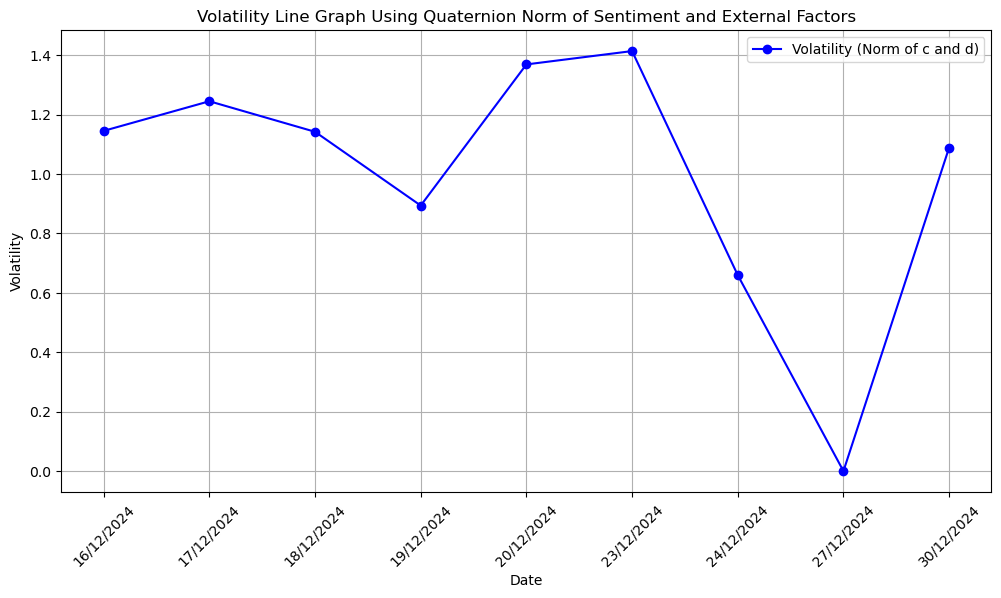

In [222]:
volatility = []

# Compute volatility from quaternion norm of c and d
for c, d in zip(df["Sentimen_Norm"], df["Faktor_Eksternal_Norm"]):
    # Create quaternion for c and d
    q = Quaternion(0, 0, c, d)
    # Compute norm to represent combined volatility
    norm = np.sqrt(q.elements[2]**2 + q.elements[3]**2)
    volatility.append(norm)

# Add volatility to DataFrame
df["Volatility"] = volatility

# Plot Volatility Line Graph
plt.figure(figsize=(12, 6))
plt.plot(df["Tanggal"], df["Volatility"], marker="o", linestyle="-", color="blue", label="Volatility (Norm of c and d)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Volatility Line Graph Using Quaternion Norm of Sentiment and External Factors")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


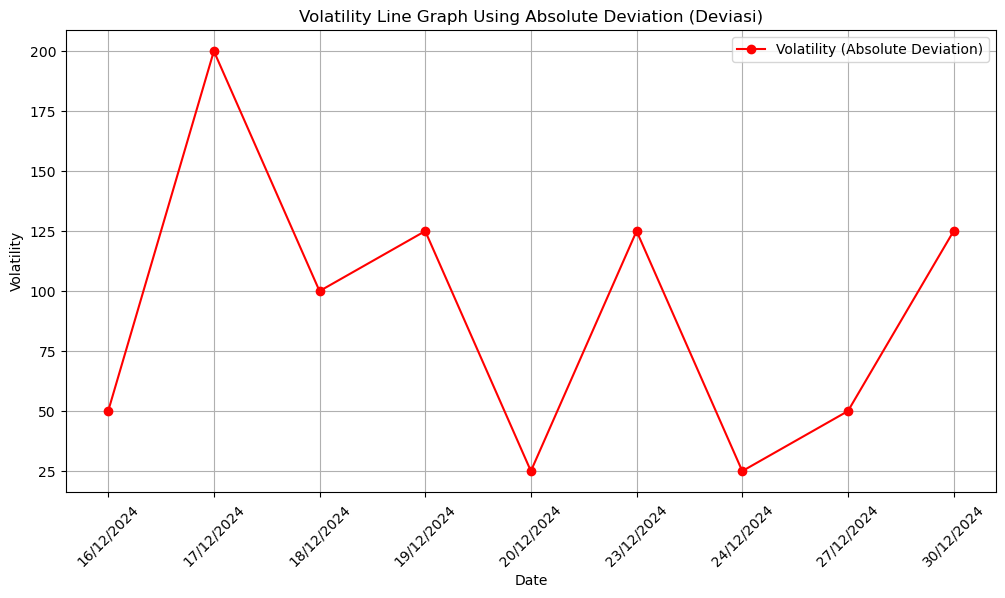

In [224]:
# Calculate the absolute deviation (volatility through deviasi)
df["Deviasi_Mutlak"] = df["Deviasi"].abs()

# Plot Volatility Line Graph
plt.figure(figsize=(12, 6))
plt.plot(df["Tanggal"], df["Deviasi_Mutlak"], marker="o", linestyle="-", color="red", label="Volatility (Absolute Deviation)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Volatility Line Graph Using Absolute Deviation (Deviasi)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


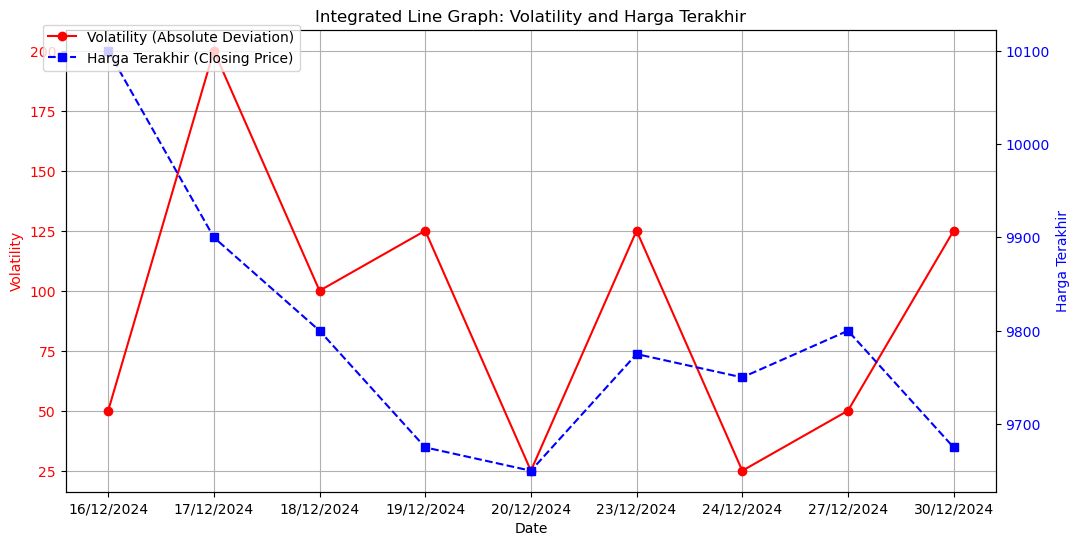

In [225]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Volatility on the primary y-axis
ax1.plot(df["Tanggal"], df["Deviasi_Mutlak"], marker="o", linestyle="-", color="red", label="Volatility (Absolute Deviation)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Volatility", color="red")
ax1.tick_params(axis="y", labelcolor="red")
ax1.set_title("Integrated Line Graph: Volatility and Harga Terakhir")
ax1.grid()

# Plot Harga Terakhir on the secondary y-axis
ax2 = ax1.twinx()  # Create a twin y-axis
ax2.plot(df["Tanggal"], df["Terakhir"], marker="s", linestyle="--", color="blue", label="Harga Terakhir (Closing Price)")
ax2.set_ylabel("Harga Terakhir", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add legends for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


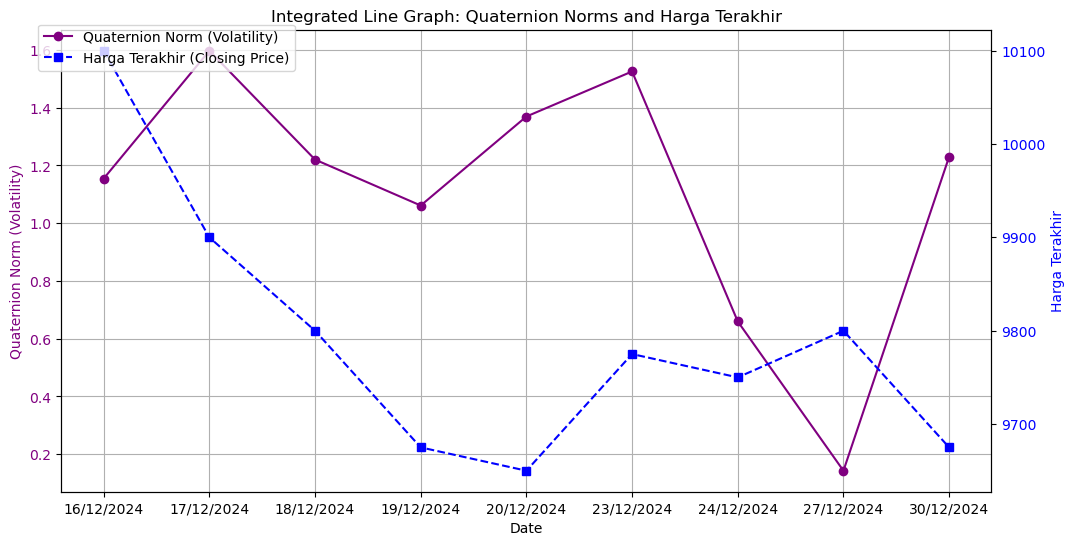

In [226]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Quaternion Norms on the primary y-axis
ax1.plot(df["Tanggal"], df["Norm"], marker="o", linestyle="-", color="purple", label="Quaternion Norm (Volatility)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Quaternion Norm (Volatility)", color="purple")
ax1.tick_params(axis="y", labelcolor="purple")
ax1.set_title("Integrated Line Graph: Quaternion Norms and Harga Terakhir")
ax1.grid()

# Plot Harga Terakhir on the secondary y-axis
ax2 = ax1.twinx()  # Create a twin y-axis
ax2.plot(df["Tanggal"], df["Terakhir"], marker="s", linestyle="--", color="blue", label="Harga Terakhir (Closing Price)")
ax2.set_ylabel("Harga Terakhir", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add legends for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


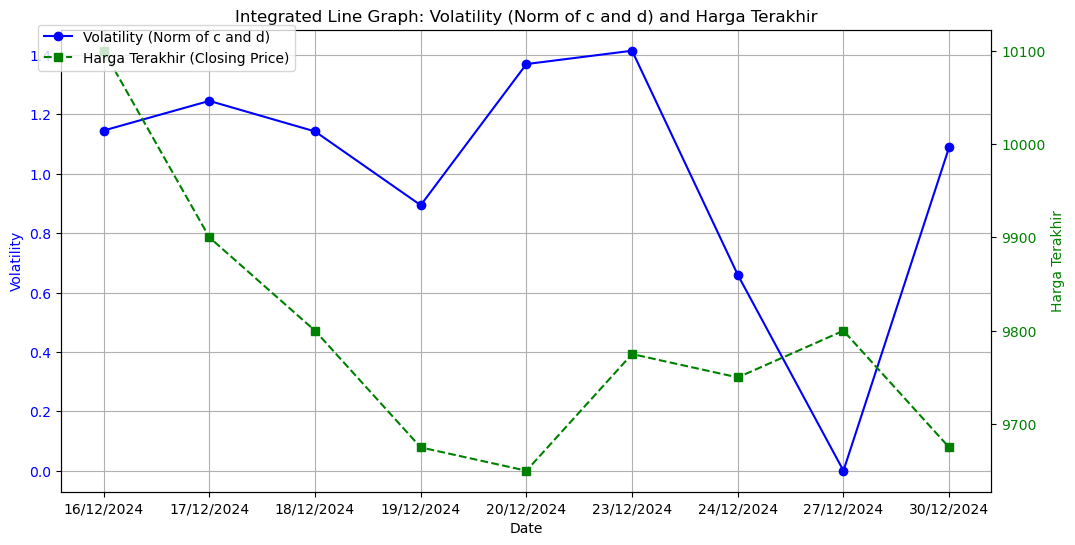

In [227]:
# Calculate quaternion-based volatility
volatility = []

for c, d in zip(df["Sentimen_Norm"], df["Faktor_Eksternal_Norm"]):
    # Create quaternion for c and d
    q = Quaternion(0, 0, c, d)
    # Compute norm to represent combined volatility
    norm = np.sqrt(q.elements[2]**2 + q.elements[3]**2)
    volatility.append(norm)

# Add volatility to DataFrame
df["Volatility"] = volatility

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Volatility on the primary y-axis
ax1.plot(df["Tanggal"], df["Volatility"], marker="o", linestyle="-", color="blue", label="Volatility (Norm of c and d)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Volatility", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_title("Integrated Line Graph: Volatility (Norm of c and d) and Harga Terakhir")
ax1.grid()

# Plot Harga Terakhir on the secondary y-axis
ax2 = ax1.twinx()  # Create a twin y-axis
ax2.plot(df["Tanggal"], df["Terakhir"], marker="s", linestyle="--", color="green", label="Harga Terakhir (Closing Price)")
ax2.set_ylabel("Harga Terakhir", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Add legends for both axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


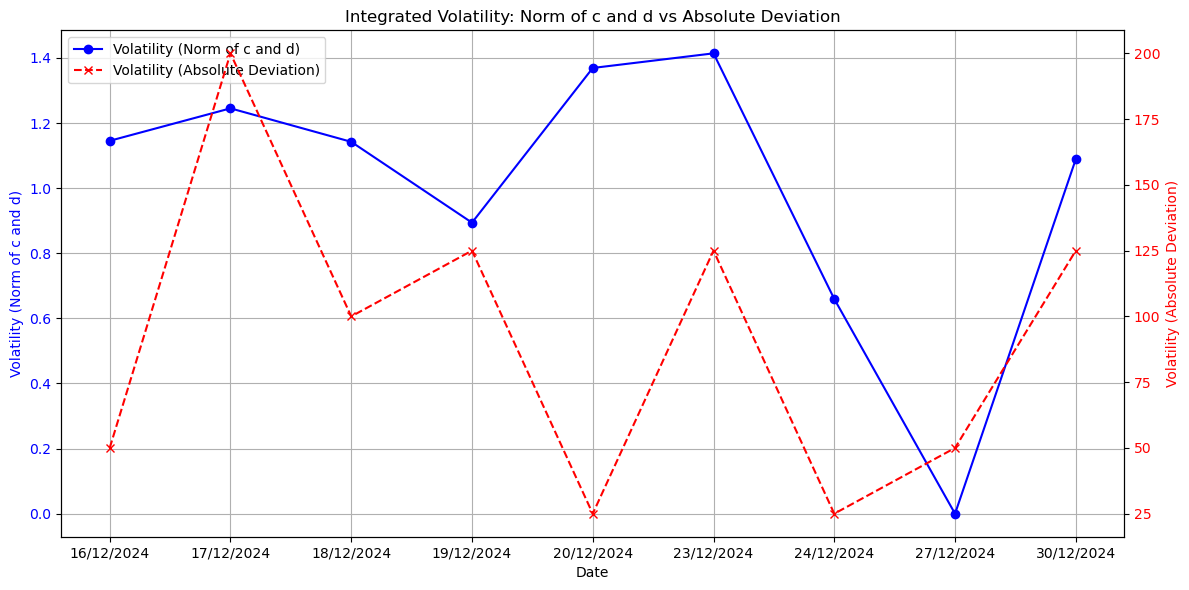

In [232]:
import matplotlib.pyplot as plt

# Compute quaternion-based volatility for c and d
volatility = []
for c, d in zip(df["Sentimen_Norm"], df["Faktor_Eksternal_Norm"]):
    # Create quaternion for c and d
    q = Quaternion(0, 0, c, d)
    # Compute norm to represent combined volatility
    norm = np.sqrt(q.elements[2]**2 + q.elements[3]**2)
    volatility.append(norm)

# Add quaternion-based volatility to DataFrame
df["Volatility_c_d"] = volatility

# Calculate absolute deviation volatility
df["Deviasi_Mutlak"] = df["Deviasi"].abs()

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Volatility (Norm of c and d) on the primary y-axis
ax1.plot(df["Tanggal"], df["Volatility_c_d"], marker="o", linestyle="-", color="blue", label="Volatility (Norm of c and d)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Volatility (Norm of c and d)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid()

# Add Absolute Deviation Volatility on the secondary y-axis
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(df["Tanggal"], df["Deviasi_Mutlak"], marker="x", linestyle="--", color="red", label="Volatility (Absolute Deviation)")
ax2.set_ylabel("Volatility (Absolute Deviation)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Add title and adjust layout
plt.title("Integrated Volatility: Norm of c and d vs Absolute Deviation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


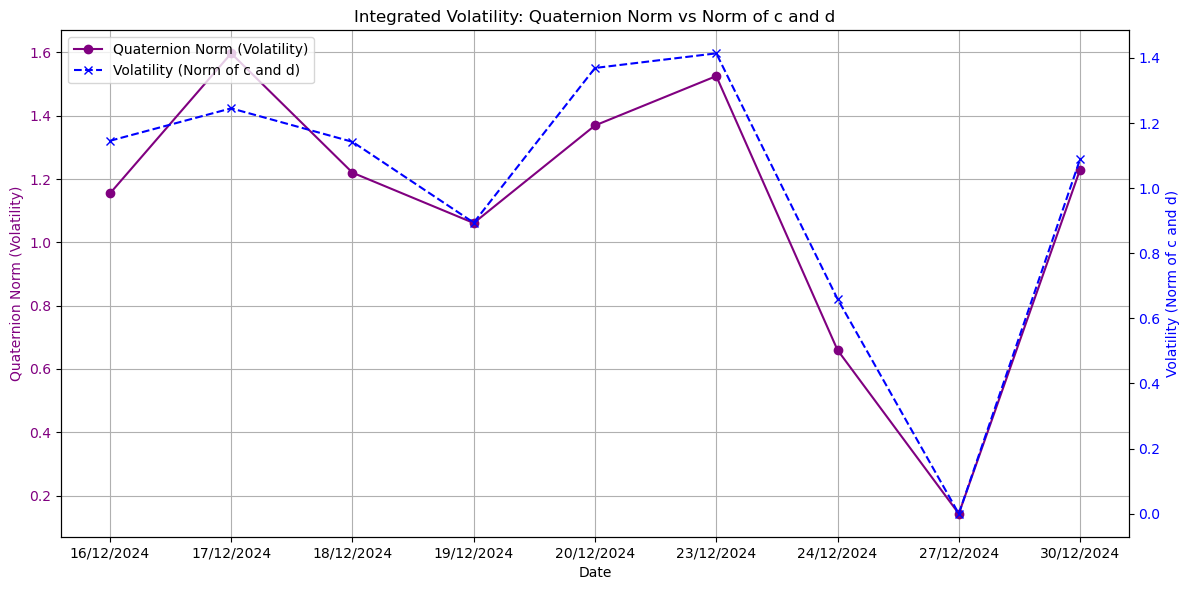

In [234]:
import matplotlib.pyplot as plt

# Compute quaternion-based volatility for c and d
volatility = []
for c, d in zip(df["Sentimen_Norm"], df["Faktor_Eksternal_Norm"]):
    # Create quaternion for c and d
    q = Quaternion(0, 0, c, d)
    # Compute norm to represent combined volatility
    norm = np.sqrt(q.elements[2]**2 + q.elements[3]**2)
    volatility.append(norm)

# Add quaternion-based volatility and absolute deviation to DataFrame
df["Volatility_c_d"] = volatility

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Quaternion Norms (Volatility) on the primary y-axis
ax1.plot(df["Tanggal"], df["Norm"], marker="o", color="purple", label="Quaternion Norm (Volatility)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Quaternion Norm (Volatility)", color="purple")
ax1.tick_params(axis="y", labelcolor="purple")
ax1.grid()

# Add Volatility (Norm of c and d) on the secondary y-axis
ax2 = ax1.twinx()  # Create a secondary y-axis
ax2.plot(df["Tanggal"], df["Volatility_c_d"], marker="x", linestyle="--", color="blue", label="Volatility (Norm of c and d)")
ax2.set_ylabel("Volatility (Norm of c and d)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Add title and adjust layout
plt.title("Integrated Volatility: Quaternion Norm vs Norm of c and d")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
